### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [1]:
student1Name="Alexander Kruglyak"
student1ID="323637736"


student2Name="Sofya Zubtsovsky"
student2ID="337839112"


The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [ ]:
!pip install imblearn

In [ ]:
!pip install imbalanced-learn


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import datetime

from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, GridSearchCV, cross_validate
from sklearn.feature_selection import SelectPercentile, f_regression


from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon

import seaborn as sns

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, PassiveAggressiveClassifier, Perceptron, RidgeClassifier, RidgeClassifierCV, SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE

import time
from xgboost import XGBClassifier

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [3]:
def show_data_basic_information(df):
    print("Info\n")
    print(df.info())
    print("\n" + "*" * 10 + "\n")
    
    print("Shape\n")
    print(full_train_df.shape) 
    print("\n" + "*" * 10 + "\n")
    
    print("Amount of is null data\n")
    print(df.isnull().sum().max())
    print("\n" + "*" * 10 + "\n")
    
    print("Describe\n")
    display(full_train_df.describe())
    print("\n" + "*" * 10 + "\n")
    
    fraud_col = df['is_fraud']
    AMOUNT_OF_FRAUD = fraud_col.value_counts()[1]
    AMOUNT_OF_FRAUD = fraud_col.value_counts()[1]
    print('No Frauds', round(fraud_col.value_counts()[0]/len(fraud_col) * 100,2), '% of the dataset')
    print('Frauds', round(fraud_col.value_counts()[1]/len(fraud_col) * 100,2), '% of the dataset')
    print('Total amount of fraud transactions:', AMOUNT_OF_FRAUD)

In [4]:
full_train_df = pd.read_csv("fraudTrain.csv")
full_test_df = pd.read_csv("fraudTest.csv")

In [5]:
show_data_basic_information(full_train_df)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 14  long        

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00



**********

No Frauds 99.42 % of the dataset
Frauds 0.58 % of the dataset
Total amount of fraud transactions: 7506


In [6]:
show_data_basic_information(full_test_df)

Info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 23 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Unnamed: 0             555719 non-null  int64  
 1   trans_date_trans_time  555719 non-null  object 
 2   cc_num                 555719 non-null  int64  
 3   merchant               555719 non-null  object 
 4   category               555719 non-null  object 
 5   amt                    555719 non-null  float64
 6   first                  555719 non-null  object 
 7   last                   555719 non-null  object 
 8   gender                 555719 non-null  object 
 9   street                 555719 non-null  object 
 10  city                   555719 non-null  object 
 11  state                  555719 non-null  object 
 12  zip                    555719 non-null  int64  
 13  lat                    555719 non-null  float64
 14  long                   555719 

,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
count,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06,1.296675e+06
mean,6.483370e+05,4.171920e+17,7.035104e+01,4.880067e+04,3.853762e+01,-9.022634e+01,8.882444e+04,1.349244e+09,3.853734e+01,-9.022646e+01,5.788652e-03
std,3.743180e+05,1.308806e+18,1.603160e+02,2.689322e+04,5.075808e+00,1.375908e+01,3.019564e+05,1.284128e+07,5.109788e+00,1.377109e+01,7.586269e-02
min,0.000000e+00,6.041621e+10,1.000000e+00,1.257000e+03,2.002710e+01,-1.656723e+02,2.300000e+01,1.325376e+09,1.902779e+01,-1.666712e+02,0.000000e+00
25%,3.241685e+05,1.800429e+14,9.650000e+00,2.623700e+04,3.462050e+01,-9.679800e+01,7.430000e+02,1.338751e+09,3.473357e+01,-9.689728e+01,0.000000e+00
50%,6.483370e+05,3.521417e+15,4.752000e+01,4.817400e+04,3.935430e+01,-8.747690e+01,2.456000e+03,1.349250e+09,3.936568e+01,-8.743839e+01,0.000000e+00
75%,9.725055e+05,4.642255e+15,8.314000e+01,7.204200e+04,4.194040e+01,-8.015800e+01,2.032800e+04,1.359385e+09,4.195716e+01,-8.023680e+01,0.000000e+00
max,1.296674e+06,4.992346e+18,2.894890e+04,9.978300e+04,6.669330e+01,-6.795030e+01,2.906700e+06,1.371817e+09,6.751027e+01,-6.695090e+01,1.000000e+00



**********

No Frauds 99.61 % of the dataset
Frauds 0.39 % of the dataset
Total amount of fraud transactions: 2145


In [7]:
def move_is_fraud_to_fisrt_index(df):
    fraud = df['is_fraud']
    df.drop(labels=['is_fraud'], axis=1,inplace = True)
    df.insert(0, 'is_fraud', fraud)
    return df

In [8]:
def show_correlation_matrices(df, annot=True):    
    df = move_is_fraud_to_fisrt_index(df)
    fig, (ax1) = plt.subplots(1, 1, figsize=(20,20))
    sns.heatmap(df.corr(), cmap='coolwarm_r', annot_kws={'size':10},annot=annot, ax=ax1)
    ax1.set_title("Data", fontsize=14)
    plt.show()

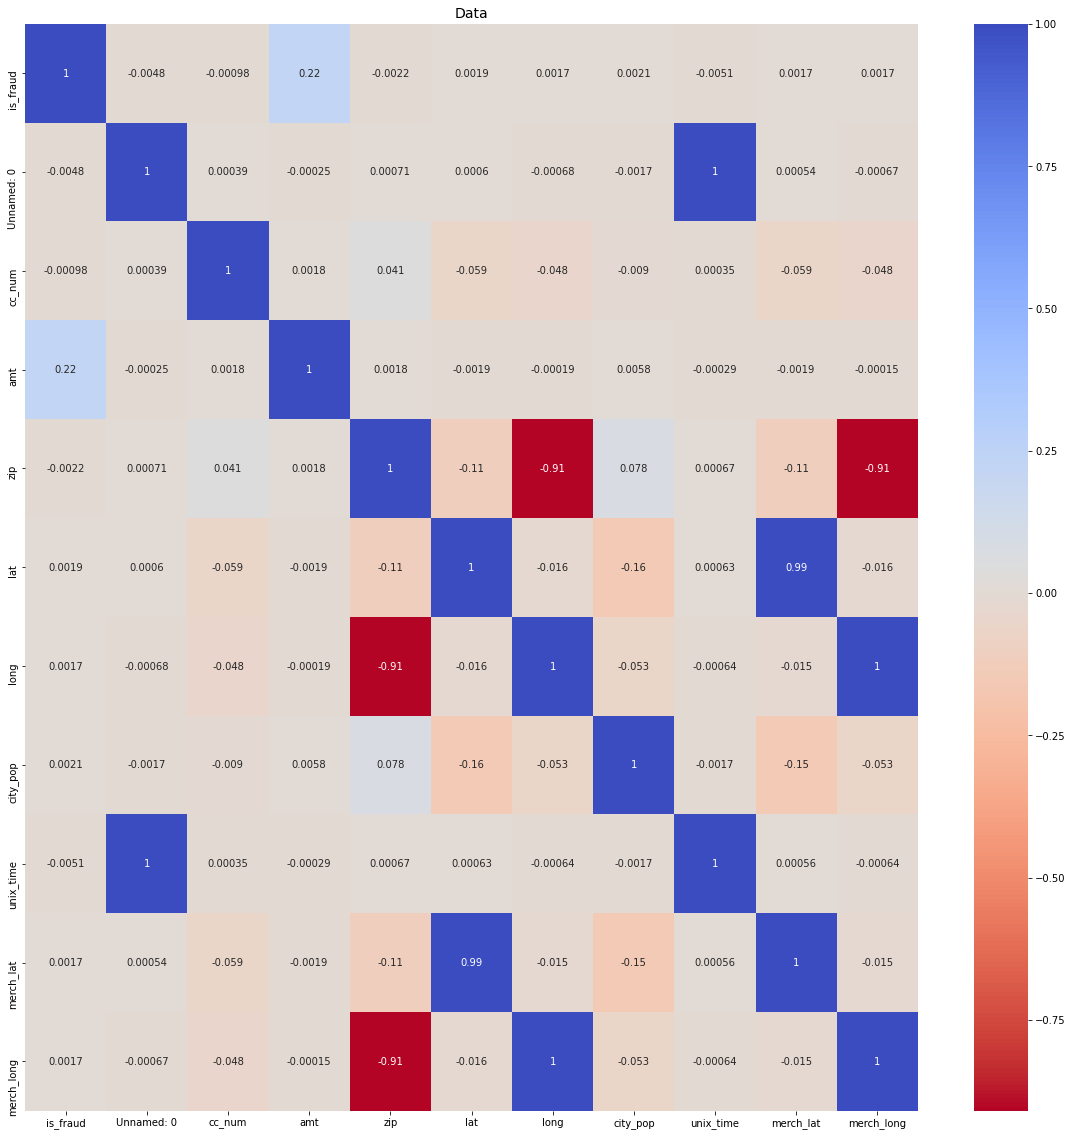

In [9]:
show_correlation_matrices(full_train_df)

In [10]:
def convert_unix_to_hour(df):
    t0 = time.time()
    _df = df.copy()
    _df['trans_hour'] = _df['unix_time']  % 86400 #(86400s per 24h)
    _df['trans_hour'] /= (86400/24)
    t1 = time.time()
    print("convert_unix_to_hour took {:.2} s".format(t1 - t0))
    return _df

convert_unix_to_hour took 0.15 s


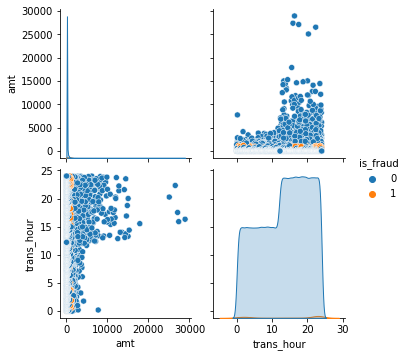

In [11]:
time_converted_train_df = convert_unix_to_hour(full_train_df)

sns.pairplot(time_converted_train_df[['amt','trans_hour', 'is_fraud']], hue='is_fraud')

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

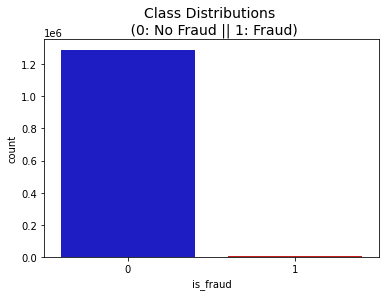

In [12]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('is_fraud', data=full_train_df, palette=colors)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

What we see here is that data is distributed abnormally, and this is very difficult to see any corelation and identify features that can be useful for our model.

We will create normally distirbuted data set and investigate it.

In [13]:
def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1,errors='ignore')

def get_label_and_drop(_df):
    df = _df.copy()
    label = df['is_fraud']
    df = drop_columns(df,['is_fraud'])
    return df, label

(1296675, 23)
(15012, 23)
[7506 7506]


Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

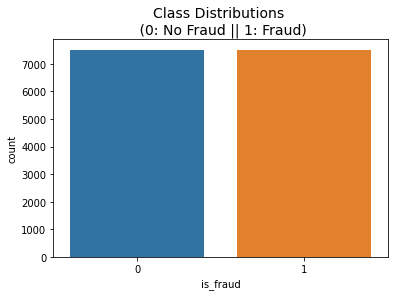

In [14]:
full_train_no_lable, full_train_label = get_label_and_drop(full_train_df)

rus = RandomUnderSampler(replacement=False,random_state=42)
normal_distributed_train_df, y_normal_distributed = rus.fit_resample(full_train_no_lable, full_train_label)
normal_distributed_train_df = pd.concat([normal_distributed_train_df,pd.DataFrame(y_normal_distributed)],axis=1)
print(full_train_df.shape)
print(normal_distributed_train_df.shape)
print(np.bincount(y_normal_distributed))
y_normal_distributed.value_counts()
sns.countplot(y_normal_distributed, data=normal_distributed_train_df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

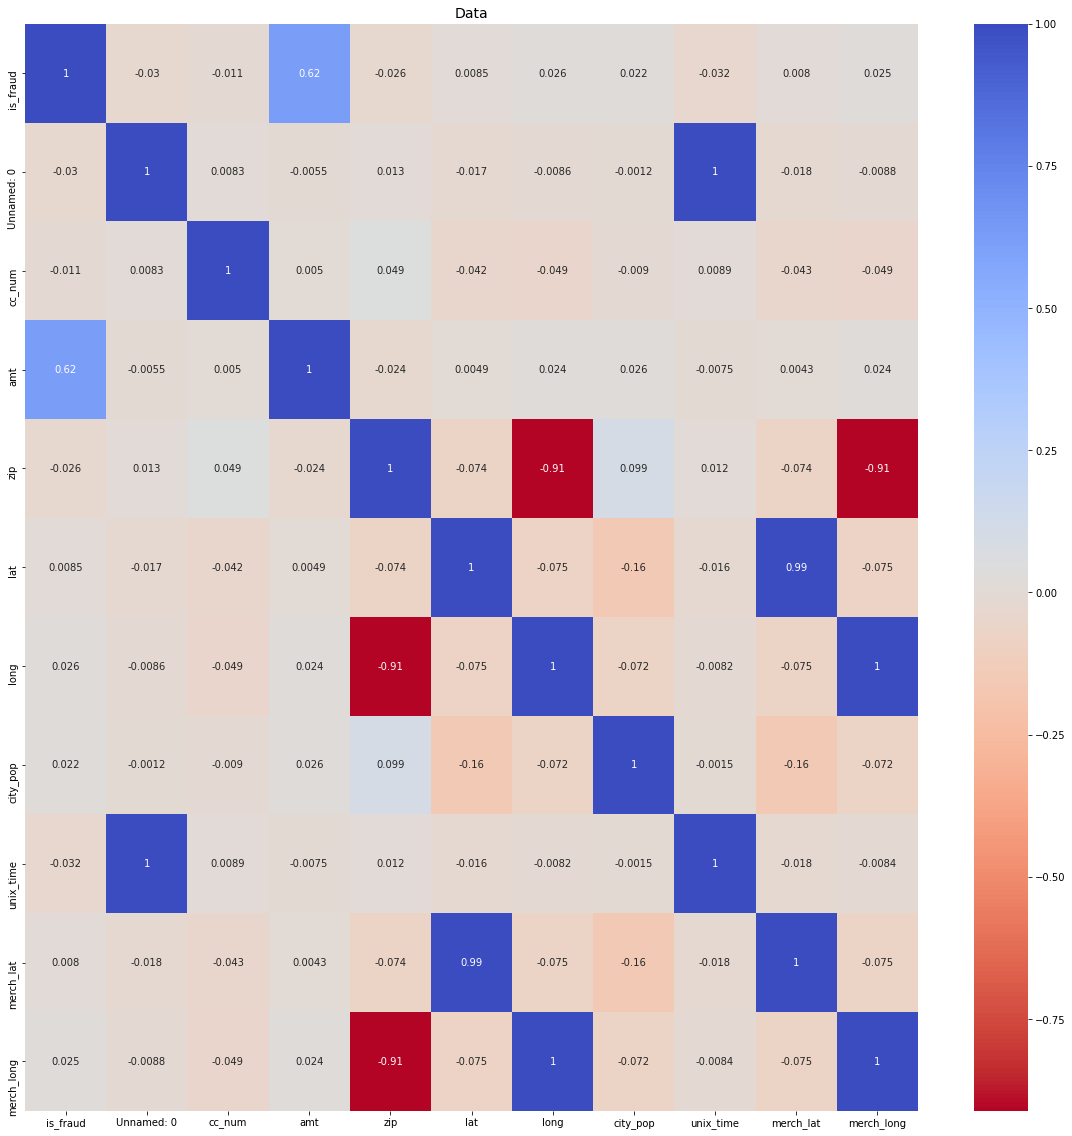

In [15]:
show_correlation_matrices(normal_distributed_train_df)

convert_unix_to_hour took 0.022 s


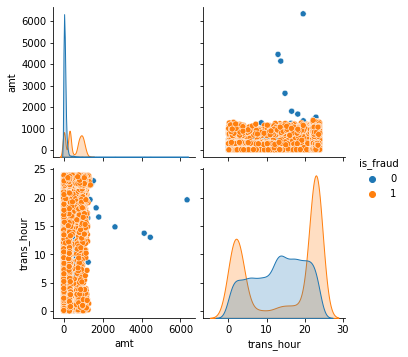

In [16]:
time_converted_normal_distributed_train_df = convert_unix_to_hour(normal_distributed_train_df)

sns.pairplot(time_converted_normal_distributed_train_df[['amt','trans_hour', 'is_fraud']], hue='is_fraud')

We can idetify 2 iportant features for fraud detection: amound and transaction hour.
Fatures first name, last name street, trans_number seem to be not relevant for fraud prediction.

In [17]:
def get_dummies(_df,columns_to_dummy):
    df = _df.copy()
    df = pd.get_dummies(df,columns=columns_to_dummy)
    return df

In [18]:
normal_distributed_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15012 entries, 0 to 15011
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   is_fraud               15012 non-null  int64  
 1   Unnamed: 0             15012 non-null  int64  
 2   trans_date_trans_time  15012 non-null  object 
 3   cc_num                 15012 non-null  int64  
 4   merchant               15012 non-null  object 
 5   category               15012 non-null  object 
 6   amt                    15012 non-null  float64
 7   first                  15012 non-null  object 
 8   last                   15012 non-null  object 
 9   gender                 15012 non-null  object 
 10  street                 15012 non-null  object 
 11  city                   15012 non-null  object 
 12  state                  15012 non-null  object 
 13  zip                    15012 non-null  int64  
 14  lat                    15012 non-null  float64
 15  lo

In [19]:
columns_to_dummy=['state','gender','category']
dummied_normal_distributed_train_df = get_dummies(normal_distributed_train_df,columns_to_dummy)

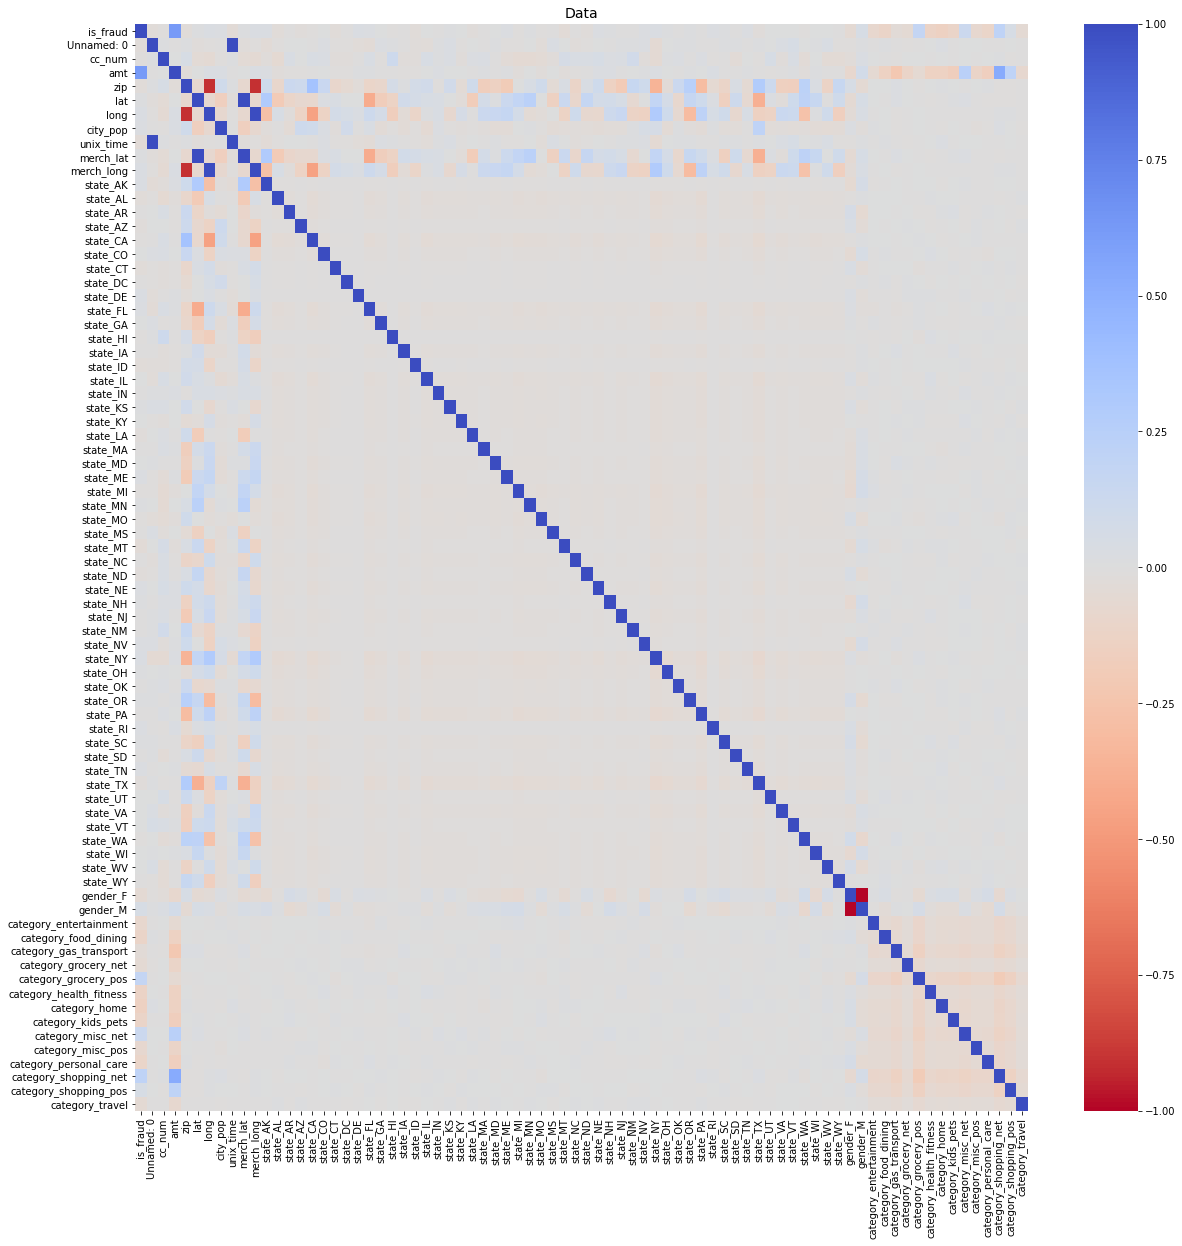

In [20]:
show_correlation_matrices(dummied_normal_distributed_train_df, False)

After encoding some of categorical varibales, we identify 3 strong features: amount, trans_hour and category

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

In [21]:
def get_sampled_data(df, percent_of_data):
    return df.sample(frac=percent_of_data,random_state=42)

In [22]:
### T R A I N  data

columns_to_drop = ['Unnamed: 0', "trans_date_trans_time", "merchant", "first", "last", "street", "city", "lat", "long", "dob", "trans_num", "merch_lat", "merch_long", "unix_time","job"]
columns_to_dummy =['gender','category','state']
sampled_train_df = get_sampled_data(full_train_df,0.05)
dummied_train_df = get_dummies(sampled_train_df,columns_to_dummy)
dummied_dropped_train_df = drop_columns(dummied_train_df,columns_to_drop)
X_train_sampled,Y_train_sampled  = get_label_and_drop(dummied_dropped_train_df)

In [23]:
X_train_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64834 entries, 1045211 to 1066301
Data columns (total 70 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cc_num                   64834 non-null  int64  
 1   amt                      64834 non-null  float64
 2   zip                      64834 non-null  int64  
 3   city_pop                 64834 non-null  int64  
 4   gender_F                 64834 non-null  uint8  
 5   gender_M                 64834 non-null  uint8  
 6   category_entertainment   64834 non-null  uint8  
 7   category_food_dining     64834 non-null  uint8  
 8   category_gas_transport   64834 non-null  uint8  
 9   category_grocery_net     64834 non-null  uint8  
 10  category_grocery_pos     64834 non-null  uint8  
 11  category_health_fitness  64834 non-null  uint8  
 12  category_home            64834 non-null  uint8  
 13  category_kids_pets       64834 non-null  uint8  
 14  category_misc_

In [24]:
regressors = [
    LogisticRegression(),
    LogisticRegressionCV(),
    PassiveAggressiveClassifier(),
    Perceptron(),
    RidgeClassifier(),
    RidgeClassifierCV(),
    SGDClassifier()
]

In [25]:
scores_df = pd.DataFrame(dtype=float)

In [26]:
def add_score(scores_df, scores, regressorName, dataType):
    scores_df.loc[regressorName + '_' + dataType, 'f1'] = scores['test_f1'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'roc_auc'] = scores['test_roc_auc'].mean()
    scores_df.loc[regressorName + '_' + dataType, 'average_precision'] = scores['test_average_precision'].mean()

In [27]:
def get_cross_val_score(scores_df,estimator,X_train,y_train,prefix="",sampler=None):
        name = estimator.__class__.__name__
        pipe = estimator
        sampler_name = ""
        if sampler is not None:
            pipe = make_imb_pipeline(sampler(random_state=42), estimator)
            sampler_name = sampler.__name__
        print('*********' + name + ' ' + sampler_name + '*********')
        full_scores = cross_validate(
            pipe,
            X_train, 
            y_train, 
            cv=5,
            scoring=('roc_auc', 'average_precision', 'f1'),
            n_jobs = -1
        )
        add_score(scores_df, full_scores, estimator.__class__.__name__,prefix)

In [28]:
for regressor in regressors:
    get_cross_val_score(scores_df,regressor,X_train_sampled,Y_train_sampled,"sampled")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [29]:
scores_df

,f1,roc_auc,average_precision
LogisticRegression_sampled,0.000000,0.500000,0.005907
LogisticRegressionCV_sampled,0.000000,0.500000,0.005907
PassiveAggressiveClassifier_sampled,0.000000,0.506807,0.007662
Perceptron_sampled,0.000000,0.506882,0.007332
RidgeClassifier_sampled,0.000000,0.822267,0.186528
RidgeClassifierCV_sampled,0.010481,0.522032,0.007250
SGDClassifier_sampled,0.000000,0.506882,0.007332


We see that linear models don't provide efiicient results on sample of original data set.

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

In [30]:
for (featureName, featureData) in full_train_df.select_dtypes(include=['object']).iteritems():
    print("{} has unique values: {}".format(featureName, featureData.nunique()))

trans_date_trans_time has unique values: 1274791
merchant has unique values: 693
category has unique values: 14
first has unique values: 352
last has unique values: 481
gender has unique values: 2
street has unique values: 983
city has unique values: 894
state has unique values: 51
job has unique values: 494
dob has unique values: 968
trans_num has unique values: 1296675


In [31]:
print(full_train_df.job.value_counts())
print(full_train_df.state.value_counts())

Film/video editor                 9779
Exhibition designer               9199
Naval architect                   8684
Surveyor, land/geomatics          8680
Materials engineer                8270
                                  ... 
Armed forces technical officer       8
Veterinary surgeon                   8
Ship broker                          7
Contracting civil engineer           7
Warehouse manager                    7
Name: job, Length: 494, dtype: int64
TX    94876
NY    83501
PA    79847
CA    56360
OH    46480
MI    46154
IL    43252
FL    42671
AL    40989
MO    38403
MN    31714
AR    31127
NC    30266
WI    29368
VA    29250
SC    29190
KY    28475
IN    27580
IA    26985
OK    26671
MD    26193
GA    26063
WV    25691
NJ    24603
NE    24168
KS    22996
MS    21188
LA    20965
WY    19322
WA    18924
OR    18597
TN    17554
ME    16505
NM    16407
ND    14786
CO    13880
MA    12376
SD    12324
VT    11768
MT    11754
AZ    10770
UT    10699
NH     8278
CT     7702
NV    

In order to see if feature engineering improves the result, we'll use the sam train data set as we used before.
- We can see that categories features have high distribution of values, so will keep 10 the most popular values from categories state and job, and deocode the rest as 'other'
### Feature engineering:
 - convert 'date of birth' feature to 'age' - age of card holder in days at the moment of transaction
 - replace features 'lat','long','merch_lat','merch_long' with new fature - distance between card holder and merchant
 - convert cc_car_number to category 'cc_type" by identifying type of credit card
 - convert zip codes - replace it with average probability of fraud per zip
 - convert 'unix_time' to day of week and to hour

In [32]:
import haversine as hs

def add_feature_holder_merch_distance(df):
    t0 = time.time()
    _df = df.copy()
    dist_list = []
    
    for index, row in df.iterrows():
        loc1=(row['lat'],row['long'])
        loc2=(row['merch_lat'],row['merch_long'])
        dist = hs.haversine(loc1,loc2,unit=hs.Unit.METERS)
        dist_list.append(round(dist,0))
    _df['holder_merch_dist'] = dist_list
    t1 = time.time()
    print("add_feature_holder_merch_distance took {:.2} s".format(t1 - t0))
    return _df

def convert_cc_to_cc_type_and_drop(df):
    t0 = time.time()
    _df = convert_cc_to_cc_type(df)
    t1 = time.time()
    print("convert_cc_to_cc_type_and_drop took {:.2} s".format(t1 - t0))
    return drop_columns(_df, ["cc_num"])

def convert_cc_to_cc_type(df):
    _df = df.copy()
    cc_category_list = []
    
    for cc in df.cc_num:
        cc_category_list.append(get_cc_type(cc))
        
    _df['cc_type'] = cc_category_list
    return _df

def get_cc_type(cc_number):
    cc_number = str(cc_number)
    if is_american_express(cc_number): return 'AMEX'
    if is_visa(cc_number): return 'VISA'
    if is_mastercard(cc_number): return 'MasterCard'
    if is_discover(cc_number): return 'Discover'
    if is_jcb(cc_number): return 'JCB'
    if is_diners_club(cc_number): return 'DinersClub'
    if is_laser(cc_number): return 'Laser'
    if is_maestro(cc_number): return 'Maestro'
    if is_visa_electron(cc_number): return 'VisaElectron'
    if is_total_rewards_visa(cc_number): return 'TotalRewardsVisa'
    if is_diners_club_carte_blanche(cc_number): return 'DinersClubCarteBlanche'
    if is_diners_club_carte_international(cc_number): return 'DinersClubCarteInt'
    
    return 'unknown'

def is_american_express(cc_number):
    """Checks if the card is an american express. If us billing address country code, & is_amex, use vpos
    https://en.wikipedia.org/wiki/Bank_card_number#cite_note-GenCardFeatures-3
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3[47][0-9]{13}$', cc_number))


def is_visa(cc_number):
    """Checks if the card is a visa, begins with 4 and 12 or 15 additional digits.
    :param cc_number: unicode card number
    """

    # Standard Visa is 13 or 16, debit can be 19
    if bool(re.match(r'^4', cc_number)) and len(cc_number) in [13, 16, 19]:
        return True

    return False


def is_mastercard(cc_number):
    """Checks if the card is a mastercard. Begins with 51-55 or 2221-2720 and 16 in length.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16 and cc_number.isdigit():  # Check digit, before cast to int
        return bool(re.match(r'^5[1-5]', cc_number)) or int(cc_number[:4]) in range(2221, 2721)
    return False


def is_discover(cc_number):
    """Checks if the card is discover, re would be too hard to maintain. Not a supported card.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16:
        try:
            # return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or cc_number[:6] in range(622126, 622926))
            return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or 622126 <= int(cc_number[:6]) <= 622925)
        except ValueError:
            return False
    return False


def is_jcb(cc_number):
    """Checks if the card is a jcb. Not a supported card.
    :param cc_number: unicode card number
    """
    # return bool(re.match(r'^(?:2131|1800|35\d{3})\d{11}$', cc_number))  # wikipedia
    return bool(re.match(r'^35(2[89]|[3-8][0-9])[0-9]{12}$', cc_number))  # PawelDecowski


def is_diners_club(cc_number):
    """Checks if the card is a diners club. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3(?:0[0-6]|[68][0-9])[0-9]{11}$', cc_number))  # 0-5 = carte blance, 6 = international


def is_laser(cc_number):
    """Checks if the card is laser. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(6304|670[69]|6771)', cc_number))


def is_maestro(cc_number):
    """Checks if the card is maestro. Not a supported card.
    :param cc_number: unicode card number
    """
    possible_lengths = [12, 13, 14, 15, 16, 17, 18, 19]
    return bool(re.match(r'^(50|5[6-9]|6[0-9])', cc_number)) and len(cc_number) in possible_lengths


# Child cards

def is_visa_electron(cc_number):
    """Child of visa. Checks if the card is a visa electron. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(4026|417500|4508|4844|491(3|7))', cc_number)) and len(cc_number) == 16


def is_total_rewards_visa(cc_number):
    """Child of visa. Checks if the card is a Total Rewards Visa. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^41277777[0-9]{8}$', cc_number))


def is_diners_club_carte_blanche(cc_number):
    """Child card of diners. Checks if the card is a diners club carte blance. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^30[0-5][0-9]{11}$', cc_number))  # github PawelDecowski, jquery-creditcardvalidator


def is_diners_club_carte_international(cc_number):
    """Child card of diners. Checks if the card is a diners club international. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^36[0-9]{12}$', cc_number))  # jquery-creditcardvalidator

def convert_dob_to_age(df): # calculate age in days at the moment of transaction
    t0 = time.time()
    _df = df.copy()
    age_in_days = []
    
    for index, row in _df.iterrows():
        birth_date  = datetime.datetime.strptime(row['dob'], '%Y-%m-%d')
        trans_date  = datetime.datetime.strptime(row['trans_date_trans_time'],'%Y-%m-%d %H:%M:%S')
        age = trans_date - birth_date
        age_in_days.append(age.days)
    
    _df['age_in_days'] = age_in_days
    t1 = time.time()
    print("convert_dob_to_age took {:.2} s".format(t1 - t0))
    return _df

def convert_dob_to_age_and_drop(df):
    t0 = time.time()
    converted_df = convert_dob_to_age(df)
    return drop_columns(converted_df, ["dob"])

from category_encoders import TargetEncoder
def target_encode_zip(data):
    t0 = time.time()
    orig_zip = data['zip']
    label = data['is_fraud']
    data_no_label = drop_columns(data,'is_fraud')
    te = TargetEncoder(cols='zip',return_df=True, drop_invariant = True).fit(data_no_label,label)
    transformed = te.transform(data_no_label)
    data['zip'] = transformed['zip'] # replace zip with fraud probability per zip
    t1 = time.time()
    print("target_encode_zip took {:.2} s".format(t1 - t0))
    return data

def convert_unix_to_day(df):
    t0 = time.time()
    _df = df.copy()
    days = []
    
    for index, row in _df.iterrows():
        day = datetime.datetime.fromtimestamp(row['unix_time']).weekday()
        days.append(day)
    
    _df['trans_day'] = days
    t1 = time.time()
    print("convert_unix_to_day took {:.2} s".format(t1 - t0))
    return _df

def convert_unix_to_hour(df):
    t0 = time.time()
    _df = df.copy()
    _df['trans_hour'] = _df['unix_time']  % 86400 #(86400s per 24h)
    _df['trans_hour'] /= (86400/24)
    t1 = time.time()
    print("convert_unix_to_hour took {:.2} s".format(t1 - t0))
    return _df

def cat_feature_to_other(df, featureName):
    _df = df.copy()
    total = len(_df[featureName].value_counts().index.to_list())
    to_default = total - 10
    less_popular = _df[featureName].value_counts().tail(to_default).index.tolist()
    _df[featureName].replace(to_replace=less_popular, value='other', inplace=True)
    return _df

def add_new_featues(_df):
    df = _df.copy()
    df = add_feature_holder_merch_distance(df)
    df = convert_cc_to_cc_type_and_drop(df)
    df = convert_dob_to_age_and_drop(df)
    df = target_encode_zip(df)
    df = convert_unix_to_day(df)
    df = convert_unix_to_hour(df)
    df = cat_feature_to_other(df,'state')
    df = cat_feature_to_other(df,'job')
    return df

In [33]:
nf_columns_to_dummy = ['gender','category','state','job','cc_type']
nf_sampled_train_df = add_new_featues(sampled_train_df)
nf_sampled_train_df = get_dummies(nf_sampled_train_df,nf_columns_to_dummy)
nf_sampled_train_df = drop_columns(nf_sampled_train_df,columns_to_drop)
X_nf_train_sampled,Y_nf_train_sampled  = get_label_and_drop(nf_sampled_train_df)

add_feature_holder_merch_distance took 4.6 s
convert_cc_to_cc_type_and_drop took 0.27 s
convert_dob_to_age took 5.3 s
target_encode_zip took 0.16 s
convert_unix_to_day took 3.6 s
convert_unix_to_hour took 0.013 s


In [34]:
X_nf_train_sampled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64834 entries, 1045211 to 1066301
Data columns (total 54 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   amt                             64834 non-null  float64
 1   zip                             64834 non-null  float64
 2   city_pop                        64834 non-null  int64  
 3   holder_merch_dist               64834 non-null  float64
 4   age_in_days                     64834 non-null  int64  
 5   trans_day                       64834 non-null  int64  
 6   trans_hour                      64834 non-null  float64
 7   gender_F                        64834 non-null  uint8  
 8   gender_M                        64834 non-null  uint8  
 9   category_entertainment          64834 non-null  uint8  
 10  category_food_dining            64834 non-null  uint8  
 11  category_gas_transport          64834 non-null  uint8  
 12  category_grocery_net    

In [35]:
for regressor in regressors:
    get_cross_val_score(scores_df,regressor,X_nf_train_sampled,Y_nf_train_sampled,"nf_sampled")

*********LogisticRegression *********
*********LogisticRegressionCV *********
*********PassiveAggressiveClassifier *********
*********Perceptron *********
*********RidgeClassifier *********
*********RidgeClassifierCV *********
*********SGDClassifier *********


In [36]:
scores_df

,f1,roc_auc,average_precision
LogisticRegression_sampled,0.000000,0.500000,0.005907
LogisticRegressionCV_sampled,0.000000,0.500000,0.005907
PassiveAggressiveClassifier_sampled,0.000000,0.506807,0.007662
Perceptron_sampled,0.000000,0.506882,0.007332
RidgeClassifier_sampled,0.000000,0.822267,0.186528
RidgeClassifierCV_sampled,0.010481,0.522032,0.007250
SGDClassifier_sampled,0.000000,0.506882,0.007332
LogisticRegression_nf_sampled,0.004938,0.660457,0.034709
LogisticRegressionCV_nf_sampled,0.000000,0.667204,0.032237
PassiveAggressiveClassifier_nf_sampled,0.000000,0.543654,0.008327


We see that feature engineering improves the results, so we can conclude that we can continue with newly added features and validate model on further steps

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

In [37]:
classifiers = [
    SVC(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier()
]

In [38]:
for classifier in classifiers:
    get_cross_val_score(scores_df,classifier,X_nf_train_sampled,Y_nf_train_sampled,"nf_sampled")

*********SVC *********
*********DecisionTreeClassifier *********
*********RandomForestClassifier *********
*********XGBClassifier *********


In [39]:
scores_df

,f1,roc_auc,average_precision
LogisticRegression_sampled,0.000000,0.500000,0.005907
LogisticRegressionCV_sampled,0.000000,0.500000,0.005907
PassiveAggressiveClassifier_sampled,0.000000,0.506807,0.007662
Perceptron_sampled,0.000000,0.506882,0.007332
RidgeClassifier_sampled,0.000000,0.822267,0.186528
RidgeClassifierCV_sampled,0.010481,0.522032,0.007250
SGDClassifier_sampled,0.000000,0.506882,0.007332
LogisticRegression_nf_sampled,0.004938,0.660457,0.034709
LogisticRegressionCV_nf_sampled,0.000000,0.667204,0.032237
PassiveAggressiveClassifier_nf_sampled,0.000000,0.543654,0.008327


From cross-validation scores we can see that in general classification models perform better than linear regressors.
SVC gives poor score, so we'll try to tune parameters for the rest of models.

In [40]:
def get_best_estimator(estimator,params,X,y,best_params_dict):
    print('*********' + estimator.__class__.__name__  + '*********')
    grid = GridSearchCV(estimator, params, n_jobs = -1)
    grid.fit(X, y)
    best_params_dict[estimator.__class__.__name__] = grid.best_params_
    return grid.best_estimator_

In [41]:
best_params_dict = {}
best_estimators = {}
params_dict = { 
    DecisionTreeClassifier():  {"criterion": ["gini", "entropy"],
                                'max_depth': [15,20,25],
                                "min_samples_leaf": list(range(5,7,1))},
    RandomForestClassifier(): {"criterion": ["gini", "entropy"],
                               'n_estimators': [400, 700, 1000],
                                'max_depth': [15,20,25],
                                'max_leaf_nodes': [50, 100, 200]},
    XGBClassifier(): {'n_estimators': [400, 700, 1000],
                    'max_depth': [15,20,25],
                     'verbosity':[1]}
}

In [ ]:
for estimator, params in params_dict.items():
    best_estimators[estimator.__class__.__name__] = get_best_estimator(estimator,params,X_nf_train_sampled,Y_nf_train_sampled,best_params_dict)

In [43]:
best_estimators

{'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5),
 'RandomForestClassifier': RandomForestClassifier(criterion='entropy', max_depth=25, max_leaf_nodes=200,
                        n_estimators=700)}

In [44]:
for name,estimator in best_estimators.items():
    get_cross_val_score(scores_df,estimator,X_nf_train_sampled,Y_nf_train_sampled,"tuned_nf_sampled")

*********DecisionTreeClassifier *********
*********RandomForestClassifier *********


In [46]:
display(scores_df.sort_values(by='f1').tail(5))
display(scores_df.sort_values(by='roc_auc').tail(5))
display(scores_df.sort_values(by='average_precision').tail(5))

,f1,roc_auc,average_precision
RandomForestClassifier_nf_sampled,0.690092,0.977966,0.844188
RandomForestClassifier_tuned_nf_sampled,0.703449,0.992742,0.879015
DecisionTreeClassifier_nf_sampled,0.717945,0.855653,0.520060
DecisionTreeClassifier_tuned_nf_sampled,0.795232,0.919773,0.742545
XGBClassifier_nf_sampled,0.834046,0.997010,0.898170


,f1,roc_auc,average_precision
DecisionTreeClassifier_tuned_nf_sampled,0.795232,0.919773,0.742545
RidgeClassifier_nf_sampled,0.086767,0.937838,0.296542
RandomForestClassifier_nf_sampled,0.690092,0.977966,0.844188
RandomForestClassifier_tuned_nf_sampled,0.703449,0.992742,0.879015
XGBClassifier_nf_sampled,0.834046,0.997010,0.898170


,f1,roc_auc,average_precision
DecisionTreeClassifier_nf_sampled,0.717945,0.855653,0.520060
DecisionTreeClassifier_tuned_nf_sampled,0.795232,0.919773,0.742545
RandomForestClassifier_nf_sampled,0.690092,0.977966,0.844188
RandomForestClassifier_tuned_nf_sampled,0.703449,0.992742,0.879015
XGBClassifier_nf_sampled,0.834046,0.997010,0.898170


In [47]:
selected_model = XGBClassifier()

According to the scores, the best results among all the models for our data gives XGBClassifier. 

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

In [48]:
def select_features(percent,X_train,y_train):
    select = SelectPercentile(score_func=f_regression, percentile=percent)
    select.fit(X_train, y_train)
    X_train_sel = select.transform(X_train)
    return select,X_train_sel

In [49]:
columns_to_drop = ['Unnamed: 0', "trans_date_trans_time", "merchant", "first", "last", "street", "city", "lat", "long", "dob", "trans_num", "merch_lat", "merch_long", "unix_time"]
nf_columns_to_dummy = ['gender','category','state','job','cc_type']
nf_full_train_df = add_new_featues(full_train_df)
nf_full_train_df = get_dummies(nf_full_train_df,nf_columns_to_dummy)
nf_full_train_df = drop_columns(nf_full_train_df,columns_to_drop)
X_nf_full_train,Y_nf_full_train  = get_label_and_drop(nf_full_train_df)

add_feature_holder_merch_distance took 9e+01 s
convert_cc_to_cc_type_and_drop took 5.2 s
convert_dob_to_age took 1.1e+02 s
target_encode_zip took 2.2 s
convert_unix_to_day took 7.2e+01 s
convert_unix_to_hour took 0.12 s


In [50]:
select,X_nf_selected = select_features(50,X_nf_full_train,Y_nf_full_train)
print(X_nf_selected.shape)
indexes = select.get_support(indices=True)
selected_features = X_nf_full_train.columns[indexes]

(1296675, 27)


In [51]:
selected_features

Index(['amt', 'zip', 'age_in_days', 'trans_day', 'trans_hour', 'gender_F',
       'gender_M', 'category_entertainment', 'category_food_dining',
       'category_gas_transport', 'category_grocery_net',
       'category_grocery_pos', 'category_health_fitness', 'category_home',
       'category_kids_pets', 'category_misc_net', 'category_misc_pos',
       'category_personal_care', 'category_shopping_net',
       'category_shopping_pos', 'category_travel',
       'job_Designer, ceramics/pottery', 'job_Systems developer', 'job_other',
       'cc_type_AMEX', 'cc_type_DinersClub', 'cc_type_Maestro'],
      dtype='object')

In [52]:
get_cross_val_score(scores_df,selected_model,X_nf_selected,Y_nf_full_train,"selected_nf")

*********XGBClassifier *********


In [54]:
get_cross_val_score(scores_df,XGBClassifier(),X_nf_full_train,Y_nf_full_train,"full_nf")

*********XGBClassifier *********


In [55]:
scores_df

,f1,roc_auc,average_precision
LogisticRegression_sampled,0.000000,0.500000,0.005907
LogisticRegressionCV_sampled,0.000000,0.500000,0.005907
PassiveAggressiveClassifier_sampled,0.000000,0.506807,0.007662
Perceptron_sampled,0.000000,0.506882,0.007332
RidgeClassifier_sampled,0.000000,0.822267,0.186528
RidgeClassifierCV_sampled,0.010481,0.522032,0.007250
SGDClassifier_sampled,0.000000,0.506882,0.007332
LogisticRegression_nf_sampled,0.004938,0.660457,0.034709
LogisticRegressionCV_nf_sampled,0.000000,0.667204,0.032237
PassiveAggressiveClassifier_nf_sampled,0.000000,0.543654,0.008327


In [56]:
nf_test_full = add_new_featues(full_test_df)
nf_test_full = get_dummies(nf_test_full,nf_columns_to_dummy)
nf_test_full = drop_columns(nf_test_full,columns_to_drop)

X_nf_test_full,Y_nf_test_full  = get_label_and_drop(nf_test_full)

add_feature_holder_merch_distance took 3.8e+01 s
convert_cc_to_cc_type_and_drop took 2.2 s
convert_dob_to_age took 4.5e+01 s
target_encode_zip took 0.86 s
convert_unix_to_day took 3e+01 s
convert_unix_to_hour took 0.047 s


In [57]:
X_nf_test_selected = select.transform(X_nf_test_full)

In [58]:
X_nf_test_selected.shape

(555719, 27)

In [59]:
X_nf_test_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555719 entries, 0 to 555718
Data columns (total 54 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   amt                             555719 non-null  float64
 1   zip                             555719 non-null  float64
 2   city_pop                        555719 non-null  int64  
 3   holder_merch_dist               555719 non-null  float64
 4   age_in_days                     555719 non-null  int64  
 5   trans_day                       555719 non-null  int64  
 6   trans_hour                      555719 non-null  float64
 7   gender_F                        555719 non-null  uint8  
 8   gender_M                        555719 non-null  uint8  
 9   category_entertainment          555719 non-null  uint8  
 10  category_food_dining            555719 non-null  uint8  
 11  category_gas_transport          555719 non-null  uint8  
 12  category_grocery

In [60]:
def train_and_predict(estimator,X_train,y_train,X_test):
    model = estimator.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return model,y_pred

In [61]:
model,y_pred = train_and_predict(XGBClassifier(),X_nf_selected,Y_nf_full_train,X_nf_test_selected)
print("Selected")

[18:14:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Selected


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.95      0.83      0.88      2145

    accuracy                           1.00    555719
   macro avg       0.97      0.91      0.94    555719
weighted avg       1.00      1.00      1.00    555719



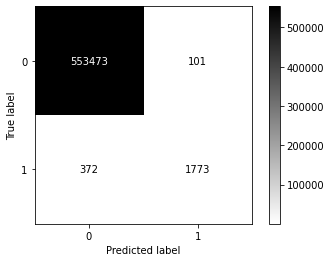

In [62]:
print(classification_report(Y_nf_test_full,y_pred))
plot_confusion_matrix(model, X_nf_test_selected, Y_nf_test_full, cmap='gray_r')

[18:16:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Entire data
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.95      0.84      0.89      2145

    accuracy                           1.00    555719
   macro avg       0.98      0.92      0.94    555719
weighted avg       1.00      1.00      1.00    555719



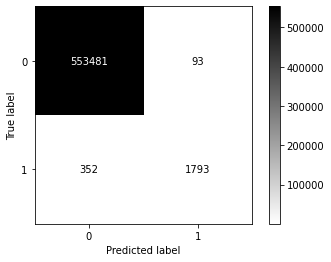

In [63]:
model_full,y_pred_full = train_and_predict(XGBClassifier(),X_nf_full_train,Y_nf_full_train,X_nf_test_full)
print("Entire data")
print(classification_report(Y_nf_test_full,y_pred_full))
plot_confusion_matrix(model_full, X_nf_test_full, Y_nf_test_full, cmap='gray_r')

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.92      0.61      0.74      2145

    accuracy                           1.00    555719
   macro avg       0.96      0.81      0.87    555719
weighted avg       1.00      1.00      1.00    555719



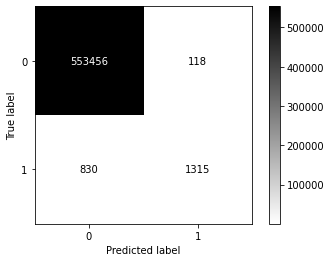

In [64]:
simple_model = DecisionTreeClassifier(max_leaf_nodes=10)
model_simple,y_pred_simple = train_and_predict(simple_model,X_nf_full_train,Y_nf_full_train,X_nf_test_full)
print(classification_report(Y_nf_test_full,y_pred_simple))
plot_confusion_matrix(model_simple, X_nf_test_full, Y_nf_test_full, cmap='gray_r')

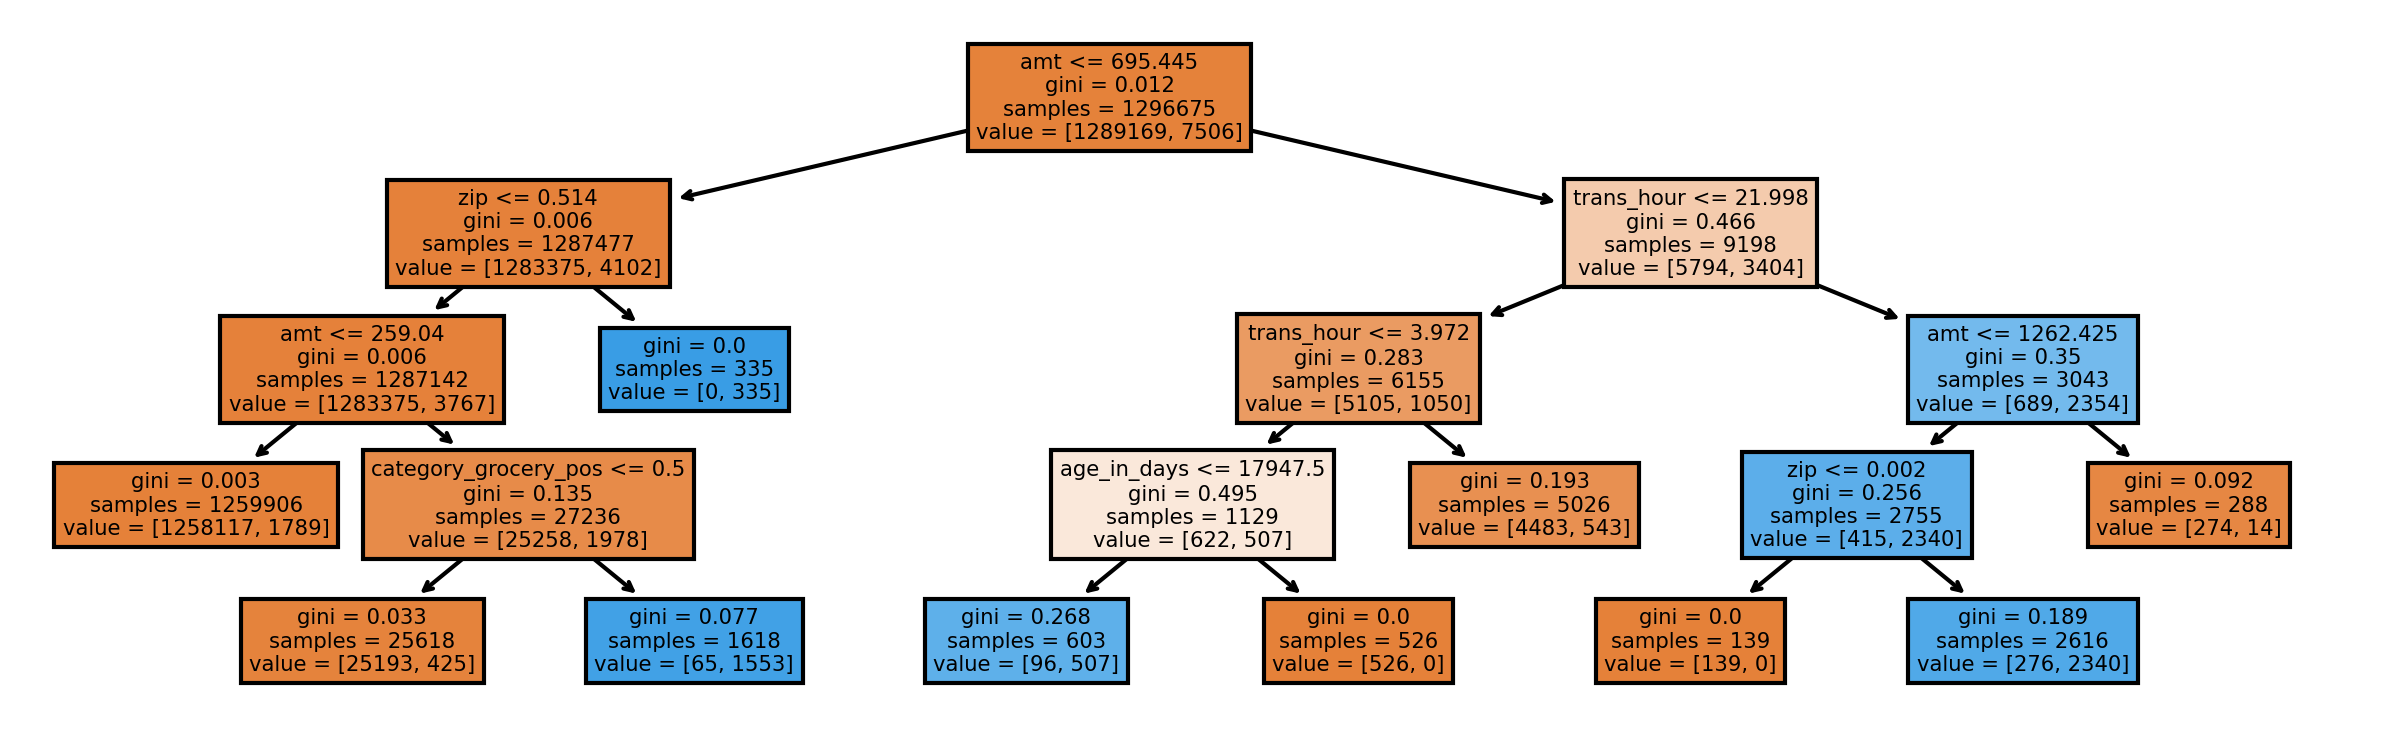

In [65]:
plt.figure(figsize=(10, 3), dpi=300)
tree_dot = plot_tree(simple_model, feature_names=X_nf_full_train.columns,filled=True)

Simple explanable model is not as good as our best model, so it worth the effort to build one.